In [ ]:
#%env CUDA_VISIBLE_DEVICES=

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as L
import torch.nn.functional as F

In [ ]:
!pip show pytorch-lightning

# PPOU-net mixture of experts:
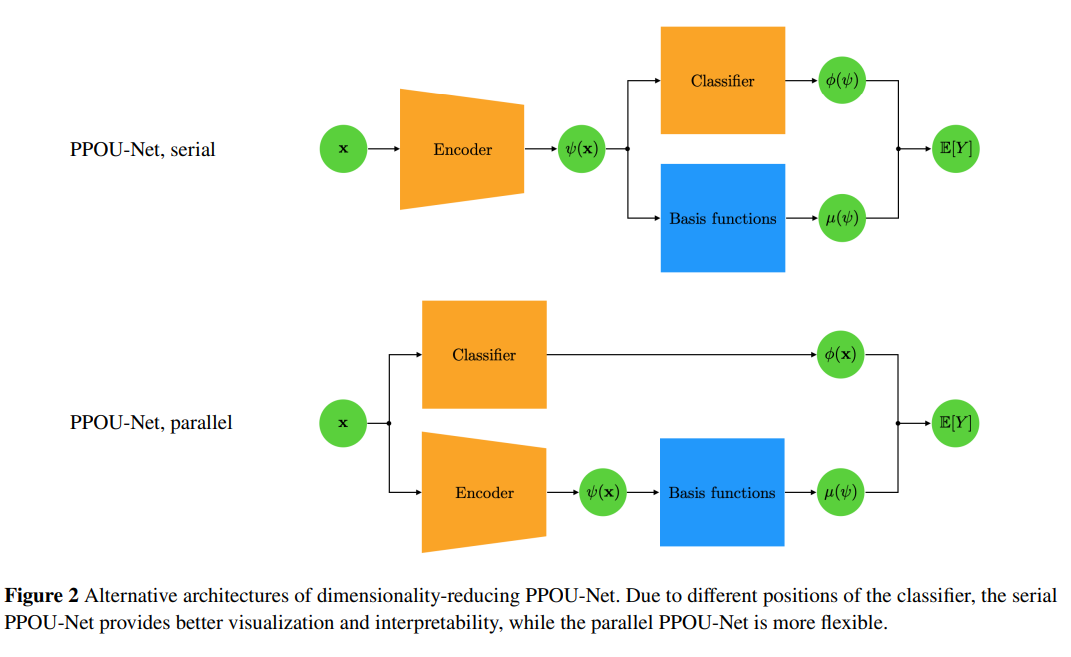

# Deterministic POU-net MoE:
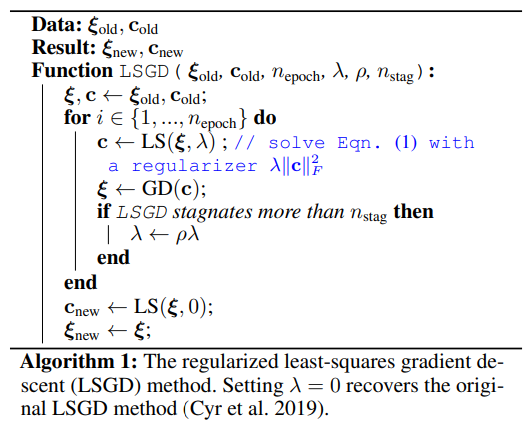
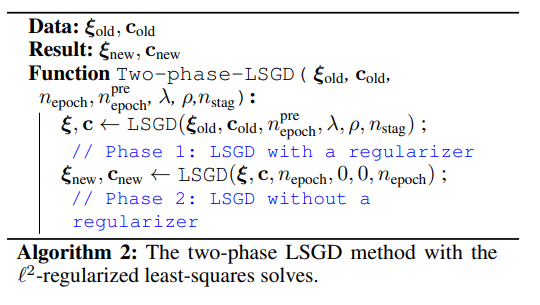
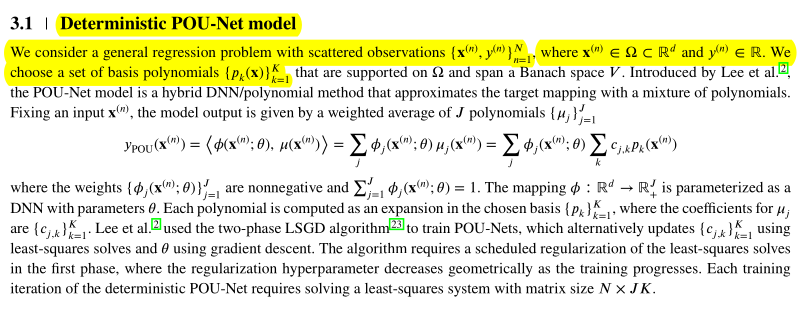

# Exercise 1

Use the deterministic Partition of Unity (POU-net) mixture of experts to fit a piecewise quadratic function on the interval, $[-1,1] \rightarrow \mathbb{R}$

This paper discuesses the method, https://arxiv.org/abs/2210.02694

But this is the basic idea:
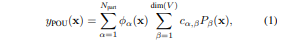

In [ ]:
import torch
from torch import nn
import numpy as np
from numpy.polynomial.polynomial import polyvander

# NOTE: maybe use this for 2d? polynomial.polynomial.polyvander2d
class PolyModule(nn.Module):
    def __init__(self, n_features=1, degree=2):
        super().__init__()
        self.degree=degree
        self.weights=nn.Parameter(torch.randn(n_features*(degree+1)))
        assert self.weights.requires_grad
    def forward(self, X):
        vander = torch.as_tensor(polyvander(X.cpu(), self.degree).reshape(X.shape[0], -1))
        return torch.matmul(vander.to(self.weights.device), self.weights)

In [ ]:
import pytorch_lightning as L
import torch.nn.functional as F

class POUnet(L.LightningModule):
    def __init__(self, n_experts = 5, n_inputs=1, make_expert = lambda: PolyModule(), lr=0.01,
                 L2_weight=1.0, L2_patience=150, L2_decay=0.9, T_max=20):
        super().__init__()
        self.gating_net = nn.Sequential(
          nn.Linear(n_inputs,20),
          nn.ReLU(),
          nn.Linear(20,20),
          nn.ReLU(),
          nn.Linear(20,20),
          nn.ReLU(),
          nn.Linear(20,n_experts),
          nn.Softmax()
        )
        self.experts=nn.ModuleList([make_expert() for i in range(n_experts)])
        vars(self).update(locals()); del self.self
    """
    def configure_optimizers(self):
        self.experts_optim = torch.optim.Adam(self.experts.parameters(), lr=self.lr, weight_decay=self.L2_weight)
        gating_optim = torch.optim.Adam(self.gating_net.parameters(), lr=self.lr)

        optims = [self.experts_optim, gating_optim]
        lr_schedulers = [torch.optim.lr_scheduler.CosineAnnealingLR(gating_optim, T_max=self.T_max)]
        return optims, lr_schedulers # this depends on pytorch-lightning <= 1.9.5
    """
    def configure_optimizers(self):
        param_groups = [{'params': self.experts.parameters(), 'weight_decay': self.L2_weight},
                        {'params': self.gating_net.parameters()}] #L2 for expert polynomials only
        self.experts_optim = torch.optim.Adam(param_groups, lr=self.lr)
        return [self.experts_optim], [torch.optim.lr_scheduler.CosineAnnealingLR(self.experts_optim, T_max=self.T_max)]
    def forward(self, X):
        X = torch.as_tensor(X)
        gating_weights = self.gating_net(X)
        prediction = 0
        for i, expert in enumerate(self.experts):
            prediction = prediction + gating_weights[:,i]*torch.as_tensor(expert(X))
        return prediction
    def on_train_start(self):
        self._lowest_loss = float('inf') # for L2 patience
        self._n_stag_steps = 0
    def _decay_L2(self, loss):
        if self._lowest_loss>loss.item():
            self._lowest_loss=loss.item()
            self._n_stag_steps=0
        else:
            self._n_stag_steps += 1
            if self._n_stag_steps%self.L2_patience==0:
                self.experts_optim.param_groups[0]['weight_decay'] *= self.L2_decay
    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_pred = self.forward(X)
        loss = F.mse_loss(y, y_pred.reshape(y.shape))
        #if optimizer_idx==1:
        self.log('loss', loss.item(), prog_bar=True)
        self.log('L2_coef', float(self.experts_optim.param_groups[0]['weight_decay']), prog_bar=True)
        self._decay_L2(loss)
        assert loss.requires_grad
        return loss
    def validation_step(self, batch, batch_idx):
        X, y = batch
        return F.mse_loss(y, self.forward(X).reshape(y.shape))

In [ ]:
def sythnetic_data_1d(N):
    x = np.random.uniform(-1,1,N).astype('float32')
    y = (x>=0)*(x-3)*(x) - 4*(x<0)*(x-1)*(x+1)
    return x,y

xtrain_1d,ytrain_1d = sythnetic_data_1d(100)
print(xtrain_1d.shape, ytrain_1d.shape)
plt.plot(xtrain_1d,ytrain_1d,'o')

In [ ]:
train_dataset = torch.utils.data.TensorDataset(torch.as_tensor(xtrain_1d).view(-1,1).float(),
                                               torch.as_tensor(ytrain_1d).view(-1,1).float())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=False)

In [ ]:
%pdb on
# train model
model = POUnet(2, lr=0.05, L2_weight=1.0, L2_decay=0.9, L2_patience=50)
trainer = L.Trainer(max_epochs=5000)
trainer.fit(model=model, train_dataloaders=train_loader)
#model.L2_weight=0.0
#trainer = L.Trainer(max_epochs=5000)
#trainer.fit(model=model, train_dataloaders=train_loader)

In [ ]:
y_pred = model(torch.as_tensor(xtrain_1d).view(-1,1)).squeeze().detach().numpy()
plt.plot(xtrain_1d,y_pred,'o')

# Exercise 2

Use deterministic POU-net to fit a piecewise quadratic function on the box, $[-1,1]\times[-1,1] \rightarrow \mathbb{R}$

In [ ]:
def sythnetic_data_2d(N):
    x = np.random.uniform(-1,1,(N,2)).astype('float32')
    x1 = x[np.sin(2.*np.pi*x)>=0.]
    x2 = x[np.sin(2.*np.pi*x)<0.]
    y = .5*(np.sin(np.pi*x[:,0])>=2*x[:,1])*(x[:,0])*(x[:,1]+1) - .5*(np.sin(np.pi*x[:,0])<2*x[:,1])*(x[:,1]-1)*(x[:,1]+1)
    return x,y

In [ ]:
# The function above generates the data that you'll fit using POU-Nets. It's a 2d function that 
xtrain_2d,ytrain_2d = sythnetic_data_2d(10000)
plt.scatter(*xtrain_2d.T,c=ytrain_2d)

In [ ]:
import torch
from torch import nn
from numpy.polynomial.polynomial import polyvander, polyvander2d

class Poly2dModule(nn.Module):
    def __init__(self, degree=2):
        super().__init__()
        n_features=2
        self.degree=[degree]*2
        self.weights=nn.Parameter(torch.randn((degree+1)**n_features))
        assert self.weights.requires_grad
    def forward(self, X):
        vander = torch.as_tensor(polyvander2d(X[:,0], X[:,1], self.degree).reshape(X.shape[0], -1))
        return torch.matmul(vander, self.weights)

In [ ]:
train_dataset = torch.utils.data.TensorDataset(torch.as_tensor(xtrain_2d).float(),
                                               torch.as_tensor(ytrain_2d).view(-1,1).float())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=False)

In [ ]:
%pdb on
# train model
model = POUnet(2, 2, make_expert=lambda: Poly2dModule(), lr=0.025,
               L2_weight=1.0, L2_decay=0.95, L2_patience=200, T_max=10)
trainer = L.Trainer(max_epochs=250)
trainer.fit(model=model, train_dataloaders=train_loader)
model.L2_weight=0.0
trainer = L.Trainer(max_epochs=250)
trainer.fit(model=model, train_dataloaders=train_loader)

In [ ]:
ypred_2d = model(torch.as_tensor(xtrain_2d)).detach().numpy()
plt.scatter(*xtrain_2d.T,c=ypred_2d)

# Exercise 3

Use POU-Net with neural operators to fit the following functional data. Working in the unit circle domain, $\Omega = \{x \in \mathbb{R}^2 : x\leq 1\}$, the true operator maps functions on $\Omega$ to functions on $\Omega$ where the both the input and output functions vanish at the boundaries of the domain. This situation is common when trying to model physical systems, e.g., the flow at the blade of a wind turbine can be assumed to be zero, but the flow elsewhere needs to be modeled. We call the details of the field behavior at the boundaries the boundary conditions.

We'll be working with an operator learning method we developed called MOR-Physics. See https://arxiv.org/pdf/1810.08552 and https://www.sciencedirect.com/science/article/pii/S004578252030685X. It's very similar to FNO. Try implementing it as described in the papers. The formula for the action of the parameterized operator is,
$$
\mathcal{N}(u) = \mathcal{F^{-1}}\left(g(\mathbf{\kappa}) \mathcal{F} (h(u)) \right)
$$
where $\mathcal{F}$ is the fourier transform, $g$ is a complex valued function of the wave vector $\kappa$, and $h$ is a point-wise nonlinearity.

Since the method is Fourier based, it only works for periodic domains, while the domain for the data is the unit circle. We can still work on the periodic domain and use MOR-Physics by embedding the circle inside a periodic domain and and use mixture of experts to fit the operator in the domain while mapping the region outside the domain to zero. See this paper for more details and generalizations of this approach in the context of numerical methods for solving PDEs, https://www.sciencedirect.com/science/article/pii/S0021999114000151

Try using MOR-physics to fit the operator in the unit circle while having it vanish outside. There's a few different levels of complexity you could try here. You could start off by fixing the POU's to be the unit circle and the region outside the circle and also fix the experts to be MOR-Physics inside the circle and the zero operator outside. Next you could try letting the POU's adopt to the domain and/or choosing between several MOR-Physics experts.

In [ ]:
import tensorflow as tf

class sythnetic_data_op_gen:
    def __init__(self):
        n = 32
        L = 2.5
        x = np.arange(-n//2,n//2)/n*L
        y = np.arange(-n//2,n//2)/n*L
        
        X = np.stack(np.meshgrid(x,y,indexing='ij'),(-1))
        Xh = np.reshape(X,(-1,2))
        self.X = X
        self.Xh = Xh
        
        Xi = X[X[...,0]**2+X[...,1]**2<1]
        Xb = X[X[...,0]**2+X[...,1]**2>=1]
        
        def K(X1,X2,a=1.,l=3e-1):
            X1shape = X1.shape
            X2shape = X2.shape
            for _ in range(len(X2shape)-1):
                X1 = X1[...,None,:]
            for _ in range(len(X1shape)-1):
                X2 = X2[None]
            d2 = tf.reduce_sum((X1-X2)**2,-1)
            return (a*tf.exp(-d2/l**2))
        
        kbb = K(Xb,Xb)
        kib = K(Xh,Xb)
        kii = K(Xh,Xh)
        
        cov = kii-np.einsum('ij,jk',kib,tf.linalg.solve(kbb,tf.transpose(kib)))
        
        self.ksq = np.linalg.cholesky(cov+1e-4*np.eye(len(Xh)))
    def true_operator(self,u):
        u2 = u**2
        return np.roll(u2,1,axis=0) + np.roll(u2,-1,axis=0) + np.roll(u2,1,axis=1) + np.roll(u2,-1,axis=1) - 4*u2
    def sample_u(self):
        u = tf.reshape(np.dot(self.ksq,np.random.normal(0,1,len(self.Xh))),(32,32)).numpy()
        u[self.X[...,0]**2+self.X[...,1]**2>=1]=0
        return u
    def sample(self,N):
        us = [self.sample_u() for _ in range(N)]
        vs = [self.true_operator(u) for u in us]
        return self.X,np.stack(us,axis=0),np.stack(vs,axis=0)

gen = sythnetic_data_op_gen()

In [ ]:
# this generates the training set. X contains the grid of (x,y) points. u_train is the input functions
# v_train is the output functions.
X,u_train,v_train = gen.sample(1000)

In [ ]:
np.save('u_train.npy', u_train)
np.save('v_train.npy', v_train)

In [ ]:
import torch
from torch import nn
import numpy as np
u_train = np.load('u_train.npy')
v_train = np.load('v_train.npy')

In [ ]:
# this plots a sample of the input functions. Note the domain boundary in red
fig,ax = plt.subplots(1,1)
plt.imshow(u_train[5],extent=[-1.25,1.25,-1.25,1.25])
ax.add_patch(plt.Circle((0, 0), 1, ec='r',fc=[0,0,0,0]))

In [ ]:
# this plots a sample of the output functions. Note the domain boundary in red
fig,ax = plt.subplots(1,1)
plt.imshow(v_train[5],extent=[-1.25,1.25,-1.25,1.25])
plt.colorbar()
ax.add_patch(plt.Circle((0, 0), 1, ec='r',fc=[0,0,0,0]))

### Wave function g hermitian symmetry:
In order for IFFT to give real results we need $ g(-\kappa)=\overline {g(\kappa)}$ \
Or you can just take real part after IFFT...

In [ ]:
'''
import torch
import torch.nn as nn
import torch.fft

# TODO: test me independently!
class MORLayer2D(L.LightningModule):
    def __init__(self, width=32, activation=nn.SELU()):
        super().__init__()
        # Define the weights in the Fourier domain (complex values)
        self.g_wave_function = \
            nn.Sequential(nn.Linear(2, width), activation,
                          nn.Linear(width,width), activation,
                          nn.Linear(width,width), activation,
                          nn.Linear(width,2))
        self.activation=activation
    def forward(self, u):
        # Apply point-wise nonlinearity h(u)
        h_u = self.activation(u) # can be any nonlinearity

        # Apply Fourier transform (last 2 dims need to be x&y!)
        u_fft = torch.fft.fft2(h_u)
        
        # Create coordinate grids using torch.meshgrid
        x = torch.linspace(0,1,steps=h_u.shape[-2])
        y = torch.linspace(0,1,steps=h_u.shape[-1])
        xx, yy = torch.meshgrid(x, y)
        
        # Stack the grids to create [batch, n_dim] inputs
        coords = torch.stack([xx, yy], dim=-1).reshape(-1, 2).to(self.device)
        
        # Create complex weights
        g = self.g_wave_function(coords)
        g = g.reshape(1, h_u.shape[-2], h_u.shape[-1], 2)
        g = torch.view_as_complex(g)
        
        # Apply learned weights in the Fourier domain
        u_fft = u_fft * g

        # Apply inverse Fourier transform
        u_ifft = torch.fft.ifft2(u_fft)

        # Return real part as output (or consider complex output if needed)
        return u_ifft.real

#class RealModule(nn.Module):
#    def forward(self, X):
#        return X.real

class LightningSequential(nn.Sequential, BasicLightningRegressor): pass
make_MOR2d_operator = lambda n_layers=5, **kwd_args: \
    LightningSequential(*([MORLayer2D(activation=nn.Identity(), **kwd_args)] +
                          [MORLayer2D(**kwd_args) for i in range(n_layers-1)]))
''';

In [ ]:
# Verified to work 7/19/24
class BasicLightningRegressor(L.LightningModule):
    """ Mixin for debugging sub-modules by training them independently. """
    def training_step(self, batch, batch_idx=None, val=False):
        X, y = batch
        y_pred = self.forward(X)
        loss = F.mse_loss(y, y_pred.reshape(y.shape))
        self.log(f'{val*"val_"}loss', loss.item(), prog_bar=True)
        return loss
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)
    def validation_step(self, batch):
        return BasicLightningRegressor.training_step(self, batch, val=True)

In [ ]:
import torch
import torch.nn as nn
import torch.fft

# Verified to work 7/19/24
class LightningSequential(nn.Sequential, BasicLightningRegressor): pass
CNN2d_layer = lambda in_size, out_size, k_size, activation=nn.SiLU: \
    nn.Sequential(nn.Conv2d(in_size, out_size, k_size, padding='same'), activation())
CNN2d = lambda in_size=1, out_size=1, k_size=3, activation=nn.SiLU, n_layers=5, filters=32: \
    LightningSequential(*([CNN2d_layer(in_size,filters,k_size,activation)] +
                          [CNN2d_layer(filters,filters,k_size,activation) for i in range(n_layers-2)] +
                          [CNN2d_layer(filters,out_size,k_size,nn.Identity)]))

# Verified to work 7/19/24
class MORLayer2D(BasicLightningRegressor):
    """ A single MOR operator layer. """
    def __init__(self, k_modes=16, activation=nn.SiLU):
        super().__init__()
        vars(self).update(locals()); del self.self
        self.g_mode_params = nn.Parameter(torch.randn(k_modes, k_modes//2+1, 2))
        self.h_mlp=CNN2d(k_size=1, activation=activation)
        # Define the weights in the Fourier domain (complex values)
    def forward(self, u):
        u = torch.as_tensor(u).to(self.device)
        
        # Apply point-wise MLP nonlinearity h(u)
        h_u = self.h_mlp(u)

        # Apply Fourier transform (last 2 dims need to be x&y!)
        u_fft = torch.fft.rfft2(h_u)

        # Convert to complex dtype & pad the g_mode_params (this will drop extra modes)
        g = torch.view_as_complex(self.g_mode_params)
        g_padded = torch.zeros(u_fft.shape[-2],u_fft.shape[-1], dtype=g.dtype, device=g.device)
        g_padded[:g.shape[0], :g.shape[1]] = g
        # ChatGPT says this is correct b/c apparently for rfft2 the lowest modes are in the top-left corner only.

        if len(u_fft.shape)==3:
            g_padded = g_padded[None]
        
        # Apply learned weights in the Fourier domain
        u_fft = u_fft * g_padded

        # Apply inverse Fourier transform
        u_ifft = torch.fft.irfft2(u_fft)

        # Return real part as output
        return u_ifft

class MOR2d_operator(BasicLightningRegressor):
    """
    Essentially a stack of MORLayer2D layers + skip connections.
    Without skip-connections this operator doesn't work at all
    (assuming multiple layers), b/c of 1 channel bottleneck.
    """
    def __init__(self, n_layers=4, **kwd_args):
        super().__init__()
        self.layers = nn.ModuleList([MORLayer2D(**kwd_args) for i in range(n_layers)])
    def forward(self, X):
        for layer in self.layers[:-1]:
            X=layer(X)+X
        return self.layers[-1](X)

# This is bad b/c no skip connections, use MOR2d_operator instead
make_MOR2d_operator = lambda n_layers=4, **kwd_args: \
    LightningSequential(*[MORLayer2D(**kwd_args) for i in range(n_layers)])

In [ ]:
import pytorch_lightning as L
import torch.nn.functional as F

# Verified to work: 7/18/24
# Double verified to work (and reproduce specific partition)
class MOR_GatingNet(BasicLightningRegressor):
    """
    Essentially a Conv MLP that outputs class probabilities across the field.
    Currently it is not actually a function of the field, just it's size (& the corresponding positions).
    """
    def __init__(self, n_inputs, n_experts, n_filters=20):
        assert n_inputs==2, 'This is currently 2d only'
        super().__init__()
        self._gating_net = nn.Sequential(
          nn.Conv2d(n_inputs,n_filters,1),
          nn.ReLU(),
          nn.Conv2d(n_filters,n_filters,1),
          nn.ReLU(),
          nn.Conv2d(n_filters,n_filters,1),
          nn.ReLU(),
          nn.Conv2d(n_filters,n_experts,1),
          nn.Softmax(dim=1)
        )
    def _make_positional_encodings(self, x_dim, y_dim):
        # Create coordinate grids using torch.meshgrid
        x = torch.linspace(0,1,steps=x_dim)
        y = torch.linspace(0,1,steps=y_dim)
        xx, yy = torch.meshgrid(x, y)
        pos_encodings = torch.stack([xx, yy], dim=0)[None]
        return pos_encodings.to(self.device)
    def forward(self, X):
        pos_encodings = self._make_positional_encodings(X.shape[-2], X.shape[-1])
        return self._gating_net(pos_encodings)

# dummy for easier debugging, possible keep it here...
class ZeroExpert(L.LightningModule):
    def forward(self, X):
        return torch.zeros_like(X)

'''
# Verified to work: 7/19/24
def fourier_series_evaluator(image_tensor):
    # Compute the n-dimensional Fourier transform
    F = torch.fft.fftn(image_tensor) # i.e. F(u,v)=F[u,v]
    dims = len(F.shape)

    def evaluate(*coords):
        assert len(coords) == dims, "Number of coordinates must match the number of dimensions"
        indices = [torch.arange(dim, dtype=torch.float32, device=F.device) for dim in F.shape]
        mesh = torch.meshgrid(*indices, indexing='ij')
        exp_term = sum(coords[i] * mesh[i] / F.shape[i] for i in range(dims))
        exponent = 2j * torch.pi * exp_term  # Corrected the exponent sign for inverse FFT
        value = torch.sum(F * torch.exp(exponent)) / torch.prod(torch.as_tensor(F.shape)).item()
        return torch.real(value).item()
    return evaluate
'''

# We need to make a new one for MoE of operators b/c input is a full field rather than coordinates.
# ^ Actually nvm! The new one might actually generalize the original even though how it would work wasn't obvious at first... 
# NOTE: this should work but is untested. We only exported the gating net & the miracle is that the forward method should still work!!
class POU_MORnet(BasicLightningRegressor):
    def __init__(self, make_expert, n_experts = 5, n_inputs=2, make_gating_net: type=MOR_GatingNet,
                 lr=0.001, L2_weight=1.0, L2_patience=10, L2_decay=0.9, T_max=25):
        super().__init__()
        n_experts+=1
        self.gating_net=make_gating_net(n_inputs=n_inputs, n_experts=n_experts)
        self.experts=nn.ModuleList([make_expert() for i in range(n_experts-1)] + [ZeroExpert()])
        vars(self).update(locals()); del self.self
    def configure_optimizers(self):
        param_groups = [{'params': self.experts.parameters(), 'weight_decay': self.L2_weight},
                        {'params': self.gating_net.parameters()}] #L2 for experts only
        self.experts_optim = torch.optim.Adam(param_groups, lr=self.lr)
        #lr_schedule = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.experts_optim, T_0=self.T_max, T_mult=2)
        lr_schedule = torch.optim.lr_scheduler.CosineAnnealingLR(self.experts_optim, T_max=self.T_max)
        return [self.experts_optim], [lr_schedule]
    # Verified to work 7/19/24
    def forward(self, X):
        X = torch.as_tensor(X).to(self.device)
        gating_weights = self.gating_net(X)
        prediction = 0
        for i, expert in enumerate(self.experts):
            prediction = prediction + gating_weights[:,i]*expert(X)
        return prediction
    def on_train_start(self):
        self._lowest_loss = float('inf') # for L2 patience
        self._n_stag_steps = 0
    # Verified to work 7/19/24
    def _decay_L2(self, loss):
        """ Decay L2 like original POU_net, but maybe not necessary for Operator MoE? """
        if self._lowest_loss>loss.item():
            self._lowest_loss=loss.item()
            self._n_stag_steps=0
        else: 
            self._n_stag_steps += 1
            if self._n_stag_steps%self.L2_patience==0:
                self.experts_optim.param_groups[0]['weight_decay'] *= self.L2_decay
    def training_step(self, batch):
        loss = super().training_step(batch)
        self.log('L2_coef', float(self.experts_optim.param_groups[0]['weight_decay']), prog_bar=True)
        self._decay_L2(loss)
        return loss

In [ ]:
'''
# make artificial data with our MOR_OperatorNet
mor_data_op=make_MOR2d_operator().to('cuda')
with torch.no_grad():
    u_train = mor_data_op(torch.as_tensor(v_train).cuda()).cpu()

# test just the operator
model=make_MOR2d_operator().to('cuda')
''';
model=CNN2d().to('cuda')

In [ ]:
u_train = torch.as_tensor(u_train).float()
v_train = torch.as_tensor(v_train).float()
train_dataset = torch.utils.data.TensorDataset(u_train[:,None], v_train[:,None])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=False)

In [ ]:
import random
X, y = next(iter(train_loader))

i = random.randrange(len(X))
print(f'id={i}')

plt.figure(1)
plt.imshow(X[i].squeeze())
plt.figure(2)
plt.imshow(y[i].squeeze())
plt.show()

In [ ]:
%pdb

In [ ]:
import torch
#torch.multiprocessing.set_start_method('spawn') # good solution !!!!

#Expert = lambda **kwd_args: make_MOR2d_operator(n_layers=1, **kwd_args) # works b/c only 1 layer
#Expert = make_MOR2d_operator # doesn't work no skip connections
Expert = MOR2d_operator # works
#Expert = CNN2d # works

# train model
model = POU_MORnet(Expert, 1, lr=0.001,
                   L2_weight=1.0, L2_decay=0.9, L2_patience=10, T_max=10)
trainer = L.Trainer(max_epochs=500, accelerator='gpu')
trainer.fit(model=model, train_dataloaders=train_loader)

In [ ]:
model.L2_weight=0.0
trainer = L.Trainer(max_epochs=1000, accelerator='gpu')
trainer.fit(model=model, train_dataloaders=train_loader)

In [ ]:
%pdb

In [ ]:
trainer.validate(model, dataloaders=train_loader)

In [ ]:
# This display loop, Verified to work 7/19/24
shuffle_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True)
model.eval()

for i, datum in enumerate(shuffle_loader):
    if i>10: break
    X, y = datum
    plt.figure(1+i*3)
    plt.imshow(X.squeeze())
    plt.colorbar()
    plt.title('Input')
    
    plt.figure(2+i*3)
    plt.imshow(y.squeeze())
    plt.colorbar()
    plt.title('Truth')
    
    plt.figure(3+i*3)
    plt.imshow(model(X.cuda()).cpu().detach().squeeze())
    plt.colorbar()
    plt.title('Pred')
    plt.show()
model.train()

## Make Inverse Fourier Function:
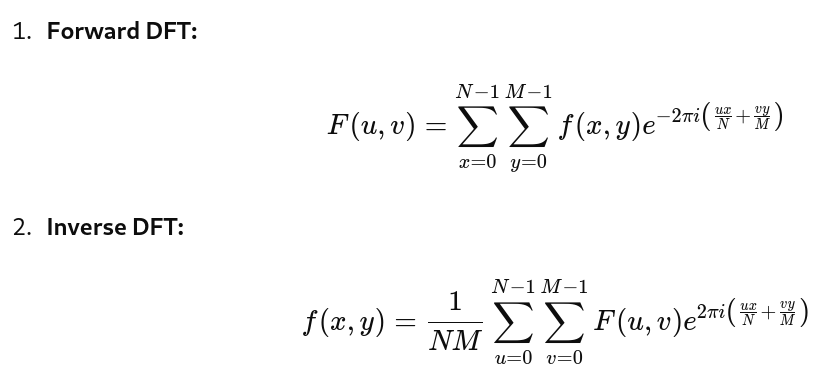

In [ ]:
F = torch.randn(3,3)
print(F)
indices = [torch.arange(dim, dtype=torch.int32, device=fft_image.device) for dim in F.shape]
mesh = torch.meshgrid(*indices, indexing='ij')
print(F[mesh[0], mesh[1]])
print(F[*mesh])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# TODO: debug special case where up-sampling doesn't work
class FourierSeriesEvaluator:
    def __init__(self, image_tensor):
        self.image_tensor=image_tensor # for sanity check
        
        # Compute the n-dimensional Fourier transform
        self.F = torch.fft.fftn(image_tensor).detach() # i.e. F(u,v)=F[u,v]
        self.dims = len(self.F.shape)
        indices = [torch.arange(dim, dtype=torch.float32, device=self.F.device) for dim in self.F.shape]
        self.mesh = torch.meshgrid(*indices, indexing='ij')
    def __call__(self, *coords):
        assert len(coords) == self.dims, "Number of coordinates must match the number of dimensions"
        exp_term = sum(coords[i] * self.mesh[i] / self.F.shape[i] for i in range(self.dims))
        exponent = 2j * torch.pi * exp_term  # Corrected the exponent sign for inverse FFT
        value = torch.sum(self.F * torch.exp(exponent)) / torch.prod(torch.as_tensor(self.F.shape)).item()
        return torch.real(value).item()
    def reconstruct_2dimage(evaluator, shape, upsampling_factor=1):
        reconstructed = torch.zeros(*[shape_i*upsampling_factor for shape_i in shape])
        for i in range(shape[0]*upsampling_factor):
            for j in range(shape[1]*upsampling_factor):
                coords = (i/upsampling_factor, j/upsampling_factor)
                reconstructed[i, j] = evaluator(*coords)
        return reconstructed
    def sanity_check2d(self, upsampling_factor=1):
        reconstructed_tensor = evaluator.reconstruct_2dimage(self.F.shape, upsampling_factor=upsampling_factor)
        # Display the original and reconstructed tensors as images
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(image_tensor.numpy(), cmap='gray')
        ax[0].set_title("Original Tensor")
        ax[1].imshow(reconstructed_tensor.numpy(), cmap='gray')
        ax[1].set_title("Reconstructed Tensor from Fourier Series")
        plt.show()
        
        # Assert that it worked (it did! wahoo!)
        if upsampling_factor==1: 
            assert (image_tensor-reconstructed_tensor).abs().mean() < 1e-6
            print('Passed equivalence assertion!')

In [ ]:
evaluator = FourierSeriesEvaluator(image_tensor)
evaluator.sanity_check2d(upsampling_factor=1)
evaluator.sanity_check2d(upsampling_factor=2)

In [ ]:
%pdb on
evaluator(0.0,0.0)

img = evaluator.reconstruct_2dimage(evaluator.F.shape, upsampling_factor=2)
img[1,1]

In [ ]:
plt.imshow(evaluator.reconstruct_2dimage(evaluator.F.shape, upsampling_factor=2)[:5,:5])
plt.colorbar()
plt.show()

In [ ]:
evaluator.F.shape

In [ ]:
import torch
import torch.fft as fft
import matplotlib.pyplot as plt
import numpy as np

# Verified to work: 7/19/24
def fourier_series_evaluator(image_tensor):
    # Compute the n-dimensional Fourier transform
    F = np.fft.fftn(image_tensor) # i.e. F(u,v)=F[u,v]
    dims = len(F.shape)

    def evaluate(*coords):
        assert len(coords) == dims, "Number of coordinates must match the number of dimensions"
        indices = [np.arange(dim, dtype='float32') for dim in F.shape]
        mesh = torch.meshgrid(*indices, indexing='ij')
        exp_term = sum(coords[i] * mesh[i] / F.shape[i] for i in range(dims))
        exponent = 2j * torch.pi * exp_term  # Corrected the exponent sign for inverse FFT
        value = torch.sum(F * torch.exp(exponent)) / torch.prod(torch.tensor(F.shape, dtype=torch.float32, device=F.device))
        return torch.real(value).item()
    return evaluate

def reconstruct_image(evaluator, shape):
    reconstructed = torch.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            coords = (i, j)
            reconstructed[i, j] = evaluator(*coords)
    return reconstructed

image_tensor = X[0].squeeze()  # Remove batch and channel dimensions for the test

fft_image = compute_fourier_transform(image_tensor)
evaluator = fourier_series_evaluator(fft_image)
reconstructed_tensor = reconstruct_image(evaluator, image_tensor.shape)

# Display the original and reconstructed tensors as images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image_tensor.numpy(), cmap='gray')
ax[0].set_title("Original Tensor")
ax[1].imshow(reconstructed_tensor.numpy(), cmap='gray')
ax[1].set_title("Reconstructed Tensor from Fourier Series")
plt.show()

# Assert that it worked (it did! wahoo!)
assert (image_tensor-reconstructed_tensor).abs().mean() < 1e-6

In [ ]:
(image_tensor-reconstructed_tensor).abs().mean()

In [ ]:
torch.prod(torch.tensor(X.shape))

In [ ]:
new_gating_net = MOR_GatingNet(2, 2)
gating_weights = new_gating_net(u_train)
target = torch.zeros_like(gating_weights)
target[0,0,:target.shape[2]//2]=1
target[0,1,target.shape[2]//2:]=1

In [ ]:
positional_encodings = new_gating_net._make_positional_encodings(target.shape[-2],target.shape[-1])
positional_encodings.shape

In [ ]:
train_dataset = torch.utils.data.TensorDataset(torch.as_tensor(v_train).float()[:1], target)
train_loader = torch.utils.data.DataLoader(train_dataset)

In [ ]:
trainer = L.Trainer(max_epochs=500, accelerator='gpu', devices=1)
trainer.fit(model=new_gating_net, train_dataloaders=train_loader)

In [ ]:
gating_weights = new_gating_net(u_train)
plt.figure(1)
plt.imshow(gating_weights[0,0].cpu().detach().numpy())
plt.colorbar()
plt.figure(2)
plt.imshow(gating_weights[0,1].cpu().detach().numpy())
plt.colorbar()

In [ ]:
gating_net = MOR_GatingNet(2, 5)

In [ ]:
%pdb on
gating_weights = gating_net(u_train)

In [ ]:
gating_weights.shape

In [ ]:
pos_encodings = gating_net._make_positional_encodings(5, 5)

In [ ]:
pos_encodings

In [ ]:
pos_encodings.shape